# Mechanistic Interpretability

## 1. Find induction heads where we know they exist. 

Take a GPT-2 or LLama model, visualize the attention patterns, and find the heads that seem to be doing induction. Additionally, see if you can automatically rank the heads by how much they attend to previous tokens like induction heads on synthetic samples `A B X_1 ... X_N A`. 

## 2. Apply the same two techniques to the ICL pretrained transformer

In [1]:
import os
from dotenv import load_dotenv

load_dotenv();

In [136]:
import torch
from torch import nn
import matplotlib.pyplot as plt

from icl.analysis.utils import get_unique_run
from devinterp.mechinterp.hooks import hook

In [3]:
run = get_unique_run(
    "../sweeps/small-sweep-2.yaml", 
    task_config={"num_tasks": 1, "num_layers": 2},
    optimizer_config={"lr": 0.01}
)

/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/icl/baselines.py:165: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  ws_hat = torch.linalg.solve(LHS, RHS)   # BKDD^-1 @ BKD1 -> B K D 1


In [53]:
# Confirm that we've loaded in the most recent model
run.evaluator(run.model)

{'pretrain/mse': 0.12384973466396332,
 'pretrain/delta_dmmse': tensor(3.3840e-06, device='mps:0'),
 'pretrain/delta_ridge': tensor(0.4832, device='mps:0'),
 'pretrain/token/0': 0.1295662224292755,
 'pretrain/token/1': 0.11031210422515869,
 'pretrain/token/2': 0.12545965611934662,
 'pretrain/token/3': 0.13209697604179382,
 'pretrain/token/4': 0.12365039438009262,
 'pretrain/token/5': 0.12712666392326355,
 'pretrain/token/6': 0.12184787541627884,
 'pretrain/token/7': 0.1207379624247551,
 'true/mse': 5.095265865325928,
 'true/delta_dmmse': tensor(7.3577e-06, device='mps:0'),
 'true/delta_ridge': tensor(3.3716, device='mps:0'),
 'true/token/0': 5.287389755249023,
 'true/token/1': 5.492154121398926,
 'true/token/2': 4.828636169433594,
 'true/token/3': 5.214682579040527,
 'true/token/4': 5.465053558349609,
 'true/token/5': 4.5970001220703125,
 'true/token/6': 5.205541610717773,
 'true/token/7': 4.671669006347656}

In [5]:
list(run.model.state_dict().keys())

['token_sequence_transformer.token_embedding.weight',
 'token_sequence_transformer.postn_embedding.weight',
 'token_sequence_transformer.blocks.0.attention.causal_mask',
 'token_sequence_transformer.blocks.0.attention.attention.weight',
 'token_sequence_transformer.blocks.0.compute.0.weight',
 'token_sequence_transformer.blocks.0.compute.0.bias',
 'token_sequence_transformer.blocks.0.compute.2.weight',
 'token_sequence_transformer.blocks.0.compute.2.bias',
 'token_sequence_transformer.blocks.0.layer_norms.0.weight',
 'token_sequence_transformer.blocks.0.layer_norms.0.bias',
 'token_sequence_transformer.blocks.0.layer_norms.1.weight',
 'token_sequence_transformer.blocks.0.layer_norms.1.bias',
 'token_sequence_transformer.blocks.1.attention.causal_mask',
 'token_sequence_transformer.blocks.1.attention.attention.weight',
 'token_sequence_transformer.blocks.1.compute.0.weight',
 'token_sequence_transformer.blocks.1.compute.0.bias',
 'token_sequence_transformer.blocks.1.compute.2.weight',
 

In [ ]:
from pathlib import Path
figures = Path("../figures/M=1/across-x-basis-w=0")

output, activations_ = hooked_model.run_with_cache(x_trick, y_trick)

def separate_attention(qkv, num_heads: int, batch_size: int, head_size: int, num_tokens: int):
    return (qkv    # B T C @ C 3C  -> B T 3C
        .view(batch_size, num_tokens, num_heads, 3*head_size)     #               -> B T H 3c
        .transpose(-2, -3)      #               -> B H T 3c
        .split(head_size, dim=-1)       #               -> (B H T c) * 3
    )

E = 64
T = 16
H = 4
B = 4

# separate_attention(activations_, num_heads=4, batch_size=4, head_size=64//4, num_tokens=16)

def optionally_rotate(x, name,):
    if len(x.shape) != 2:
        raise ValueError("Tensor should have two dimensions.")

    if x.shape[0] > x.shape[1]:
        return x.T, f"{name}.T"
    
    return x, name

activations = {}
activations["x"] = x_trick
activations["y"] = y_trick
activations.update(activations_)

for i in range(4):
    if not os.path.exists(figures / f"{i}"):
        os.makedirs(figures / f"{i}")

    for location, v in activations.items():
        activation_slice = v[i] # Batch idx

        if location.endswith("attention.attention"):
            q, k, v = separate_attention(v, num_heads=H, batch_size=B, head_size=E//H, num_tokens=T)
            qk = q @ k.transpose(-2, -1)
            q, k, qk, v = q[i], k[i], v[i], qk[i]
            
            fig, axs = plt.subplots(H, 4, figsize=(15, 15))

            for j, (name, x) in enumerate(zip(["Q", "K", "QK", "V"], [q, k, qk, v])):
                for h in range(H):
                    ax = axs[h, j]
                    ax.matshow(x[h].detach().to("cpu").numpy())
                    ax.set_title(f"{h}.{name}")

            plt.suptitle(f"{location}")
            plt.savefig(figures / f"{i}/{location}.png")
            plt.show()
        elif len(activation_slice.shape) == 2:
            x, name = optionally_rotate(activation_slice, location)
            plt.matshow(x.detach().to("cpu").numpy())
            plt.title(f"{i} {name}")
            plt.savefig(figures / f"{i}/{name}.png")
            plt.show()
        elif len(activation_slice.shape) == 3:  # [heads, xs, ys]
            heads, xs, ys = activation_slice.shape
            fig, axs = plt.subplots(1, heads, figsize=(15, 15))
            for j in range(heads):
                ax = axs[j]
                x, name = optionally_rotate(activation_slice[j], str(j))
                ax.matshow(x.detach().to("cpu").numpy())
                ax.set_title(name)
            plt.suptitle(f"{location}.#")
            plt.savefig(figures / f"{i}/{location}.png")
            plt.show()
        else:
            raise ValueError("Unsupported number of dimensions.")


In [ ]:
import os
from PIL import Image

# List of folder paths containing images
folder_paths = [figures / f"{i}" for i in range(4)]  # Add more folders as needed

if not os.path.exists(figures / "overview"):
    os.makedirs(figures/"overview")

# Create a dictionary to store images by filename
images_by_filename = {}

# Load images from each folder and organize them by filename
for folder_path in folder_paths:
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.png')]  # Change the extension as needed
    for filename in filenames:
        img = Image.open(os.path.join(folder_path, filename))
        if filename in images_by_filename:
            images_by_filename[filename].append(img)
        else:
            images_by_filename[filename] = [img]

print(images_by_filename)

# Create comparison images for each unique filename
for filename, image_list in images_by_filename.items():
    # Calculate the width and height of the result image
    width = sum(img.width for img in image_list)
    height = max(img.height for img in image_list)

    # Create a new image for the comparison
    result_image = Image.new('RGB', (width, height))

    # Paste images side by side
    x_offset = 0
    for img in image_list:
        result_image.paste(img, (x_offset, 0))
        x_offset += img.width

    # Display or save the result image
    result_image.save(figures / f"overview/{filename}")  # You can replace this with result_image.save() to save the comparison images

In [ ]:
from copy import deepcopy
import operator
from typing import Callable, List

def patch(module: nn.Module):
    if isinstance(module, nn.ModuleList):
        return PatchedList(module)
    elif isinstance(module, nn.Sequential):
        return PatchedSequential(module)
    else:
        return Patched(module)


class Patched(nn.Module):
    def __init__(self, module: nn.Module):
        super().__init__()
        self.__dict__["_current"] = module
        self.__dict__["_original"] = module

        for n, c in self._current.named_children():
            print(n, c)
            self.add_module(n, patch(c))

    def forward(self, *args, **kwargs):
        return self._current(*args, **kwargs)
    
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return self._current.__getattr__(name)
        
    def __setattr__(self, name, value):
        current_value = getattr(self, name)

        if isinstance(current_value, (Patched, PatchedList, PatchedSequential)):
            current_value._current = value
        else:
            super().__setattr__(name, value)

    def set(self, new_value):
        self._current = new_value
    
    def reset(self):
        self._current = self._original

        for c in self._current.children():
            if isinstance(c, (Patched, PatchedList, PatchedSequential)):
                c.reset()

    @property
    def _current(self):
        return self.__dict__["_current"]
    
    @property
    def _original(self):
        return self.__dict__["original"]


class PatchedList(nn.Module):
    def __init__(self, module_list: nn.ModuleList):
        super().__init__()
        module_list = [patch(c) for c in module_list]
        self.__dict__["_current"] = module_list
        self.__dict__["_original"] = module_list

        for i, module in module_list:
            self.add_module(str(i), module)

    def __setattr__(self, name, value):
        current_value = getattr(self, name)

        if isinstance(current_value, (Patched, PatchedList, PatchedSequential)):
            current_value._current = value
        else:
            super().__setattr__(name, value)

    def __setitem__(self, index, value):
        self[index].set(value)

    def __getitem__(self, index):
        return self._current[index]
    
    def __iter__(self):
        return iter(self._current)
    
    def __len__(self):
        return len(self._current)

    def set(self, new_value):
        self._current = new_value
    
    def reset(self):
        self._current = self._original

        for c in self:
            if isinstance(c, (Patched, PatchedList, PatchedSequential)):
                c.reset()

    @property
    def _current(self):
        return self.__dict__["_current"]
    
    @property
    def _original(self):
        return self.__dict__["original"]
    
class PatchedSequential(PatchedList):
    def forward(self, x):
        for layer in self:
            x = layer(x)

        return x


def set_head_to(i, output):
    def new_softmax(self, x):
        y = nn.functional.softmax(x, dim=-1)
        y[:, i, :, :] = output
        return y 
    
    return new_softmax

def set_heads_to(mappings):
    def new_softmax(self, x):
        y = nn.functional.softmax(x, dim=-1)

        for k, v in mappings.items():
            y[:, k, :, :] = v
        return y 
    
    return new_softmax

class Patch(nn.Module):
    def __init__(self, callable: Callable):
        self.callable = callable

    def forward(self, *args, **kwargs):
        return self.callable(*args, **kwargs)


def patch_(module: nn.Module, callable: Callable):
    if isinstance(module, Hooked):
        module._original = module._forward
        module._forward = callable

        def reset():
            module._forward = module._original
            del module._forward
            del module.reset

        module.reset = reset
        return module

    else:
        module._original = module.forward
        module.forward = callable

        def reset():
            module.forward = module._original
            del module._forward
            del module.reset

        module.reset = reset
        return module

model = deepcopy(run.model)
patched_model = model #  patch(model)
hooked_patched_model = hook(patched_model) # hook(patch(run.model))

def apply_binop_dicts(d1, d2, op):
    return {
        k: op(d1[k], d2[k]) for k in d1.keys()
    }

# probe = ActivationProbe(masked_model, "token_sequence_transformer.blocks.0.attention.attention_softmax")
# probe.register_hook()
_, activations = hooked_patched_model.run_with_cache(x_trick[:2], y_trick[:2])
plot_activations([activations["token_sequence_transformer.blocks.0.attention.attention_softmax"]])

evals_1 = run.evaluator(hooked_patched_model)

head_2 = torch.zeros((16, 16), device="mps")
for i in range(0,16, 2):
    head_2[i, i] = 1

for i in range(0, 16, 2):
    head_2[i+1, i] = head_2[i+1, i+1] = 0.5


head_3 = torch.zeros((16, 16), device="mps")
for i in range(15):
    head_3[i+1, i] = 1
head_3[0, 0] = 1

layer = patch_(hooked_patched_model.token_sequence_transformer.blocks[0].attention.attention_softmax, set_heads_to({1: head_2, 2: head_3}))
_, activations = hooked_patched_model.run_with_cache(x_trick[:2], y_trick[:2])
plot_activations([activations["token_sequence_transformer.blocks.0.attention.attention_softmax"]])

evals_2 = run.evaluator(hooked_patched_model)

apply_binop_dicts(evals_1, evals_2, lambda x, y: (y-x)/x)


In [ ]:
# Ready to investigate
run.model

In [ ]:
from typing import List
from torchtyping import TensorType


def get_attention(model, xs, ys):
    num_layers = len(model.token_sequence_transformer.blocks)
    probes = []

    for b in range(num_layers):
        probe = ActivationProbe(model, f"token_sequence_transformer.blocks.{b}.attention.attention_softmax")
        probe.register_hook()
        probes.append(probe)

    # Run the model
    model(xs, ys)

    for probe in probes:
        probe.unregister_hook()

    # Get the activations
    return [probe.activation for probe in probes]

def plot_activations(activations: List[TensorType["batch", "heads", "tokens", "tokens"]]):       
    num_layers = len(activations)
    num_samples, num_heads, num_tokens, _ = activations[0].shape

    for sample_idx in range(num_samples):
        # Create a new figure
        plt.figure(figsize=(15, 4 * num_layers))

        # Loop through each head
        for layer_idx, activation in enumerate(activations):
            for head_idx in range(num_heads):
                head_activation = activation[sample_idx, head_idx].detach().cpu().numpy()

                # Create a subplot for each head
                ax = plt.subplot(num_layers, num_heads, layer_idx * num_heads + head_idx + 1)

                # Plot the activation
                ax.imshow(head_activation, cmap='viridis', aspect='auto')

                # Add title and labels
                ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
                ax.set_xlabel('Keys')
                ax.set_ylabel('Queries')

        plt.tight_layout()
        plt.show()

def compose2(f, g):
    return lambda *a, **kw: f(g(*a, **kw))

def compose(*fs):
    from functools import reduce
    return reduce(compose2, fs)

get_and_plot_activations = compose(plot_activations, get_attention)

In [ ]:
ws = run.pretrain_dist.task_distribution.tasks
print(ws)

In [ ]:
from icl.tasks import apply_transformations

# x_trick = torch.zeros((4, 8, 4))
# x_trick[:, :, 0] = torch.arange(0, 8)
# # y_trick = torch.zeros((1, 8, 1))
# x_trick = x_trick.to("mps")
# y_trick = apply_transformations(ws, x_trick, run.pretrain_dist.std, device="mps")

x_trick = torch.zeros((4, 8, 4))
for i in range(4):
    x_trick[i, :, i] = torch.arange(0, 8)

# y_trick = torch.zeros((1, 8, 1))
x_trick = x_trick.to("mps")
y_trick = apply_transformations(ws[0].repeat(4), x_trick, run.pretrain_dist.std, device="mps")

for i in range(4):
    plt.matshow(x_trick[i].T.detach().cpu().numpy())

plt.matshow(y_trick.detach().cpu().numpy())

In [ ]:
# xs, ys = run.pretrain_dist.get_batch(8, 1)
# get_and_plot_activations(run.model, xs=xs, ys=ys)
get_and_plot_activations(run.model, xs=x_trick, ys=y_trick)

In [ ]:
run_2 = get_unique_run(
    "../sweeps/small-sweep.yaml", 
    task_config={"num_tasks": 65536, "num_layers": 2},
    optimizer_config={"lr": 0.001}
)

xs_2, ys_2 = run_2.pretrain_dist.get_batch(8, 1)
get_and_plot_activations(run_2.model, xs=xs_2, ys=ys_2)
get_and_plot_activations(run_2.model, xs=x_trick, ys=y_trick)

In [ ]:
run_3 = get_unique_run(
    "../sweeps/small-sweep.yaml", 
    task_config={"num_tasks": 64, "num_layers": 2},
    optimizer_config={"lr": 0.001}
)

xs_3, ys_3 = run_3.pretrain_dist.get_batch(8, 1)
get_and_plot_activations(run_3.model, xs=xs_3, ys=ys_3)
get_and_plot_activations(run_3.model, xs=x_trick, ys=y_trick)

# Reverse Engineering

In [135]:
import numpy as np
from icl.model import from_predicted_token_sequence, to_token_sequence

activations = []

class EmbedUnembedOnly(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.to_token_sequence = to_token_sequence
        self.token_embedding = model.token_sequence_transformer.token_embedding
        self.positional_embedding = model.token_sequence_transformer.postn_embedding
        self.unembedding = model.token_sequence_transformer.unembedding
        self.from_predicted_token_sequence = from_predicted_token_sequence

    def forward(self, xs, ys):
        tokens = self.to_token_sequence(xs, ys)

        T = tokens.shape[1]
        x = self.token_embedding(tokens) + self.positional_embedding.weight.T[:T, :]
        # Set everything to zero except for dimensions 46 and 51
        # embedded[:, :, :46] = 0
        # embedded[:, :, 47:51] = 0
        # embedded[:, :, 52:] = 0

        # unembedded = self.unembedding[0](x)
        unembedded = self.unembedding[1](x / 25)

        # raise ValueError("Done")
    
        return self.from_predicted_token_sequence(unembedded)


embed_unembed_only_model = EmbedUnembedOnly(run.model)
run.evaluator(embed_unembed_only_model)

{'pretrain/mse': 0.1272483468055725,
 'pretrain/delta_dmmse': tensor(0.0032, device='mps:0'),
 'pretrain/delta_ridge': tensor(0.4455, device='mps:0'),
 'pretrain/token/0': 0.13374899327754974,
 'pretrain/token/1': 0.11237277090549469,
 'pretrain/token/2': 0.1297406107187271,
 'pretrain/token/3': 0.13376107811927795,
 'pretrain/token/4': 0.12727957963943481,
 'pretrain/token/5': 0.13120131194591522,
 'pretrain/token/6': 0.12555132806301117,
 'pretrain/token/7': 0.12433113902807236,
 'true/mse': 4.994413375854492,
 'true/delta_dmmse': tensor(0.0033, device='mps:0'),
 'true/delta_ridge': tensor(3.2730, device='mps:0'),
 'true/token/0': 5.189401149749756,
 'true/token/1': 5.38076114654541,
 'true/token/2': 4.716647148132324,
 'true/token/3': 5.119599342346191,
 'true/token/4': 5.341472625732422,
 'true/token/5': 4.512819766998291,
 'true/token/6': 5.117273330688477,
 'true/token/7': 4.577332496643066}

In [138]:
hooked_model = hook(run.model)

In [140]:
activations = hooked_model.run_with_cache(run.evaluator.pretrain_xs, run.evaluator.pretrain_ys)[1]
activations.keys()

dict_keys(['token_sequence_transformer', 'token_sequence_transformer.token_embedding', 'token_sequence_transformer.postn_embedding', 'token_sequence_transformer.blocks.0', 'token_sequence_transformer.blocks.0.attention', 'token_sequence_transformer.blocks.0.attention.attention', 'token_sequence_transformer.blocks.0.attention.attention_softmax', 'token_sequence_transformer.blocks.0.compute.0', 'token_sequence_transformer.blocks.0.compute.1', 'token_sequence_transformer.blocks.0.compute.2', 'token_sequence_transformer.blocks.0.layer_norms.0', 'token_sequence_transformer.blocks.0.layer_norms.1', 'token_sequence_transformer.blocks.0.resid_after_attn', 'token_sequence_transformer.blocks.1', 'token_sequence_transformer.blocks.1.attention', 'token_sequence_transformer.blocks.1.attention.attention', 'token_sequence_transformer.blocks.1.attention.attention_softmax', 'token_sequence_transformer.blocks.1.compute.0', 'token_sequence_transformer.blocks.1.compute.1', 'token_sequence_transformer.bloc

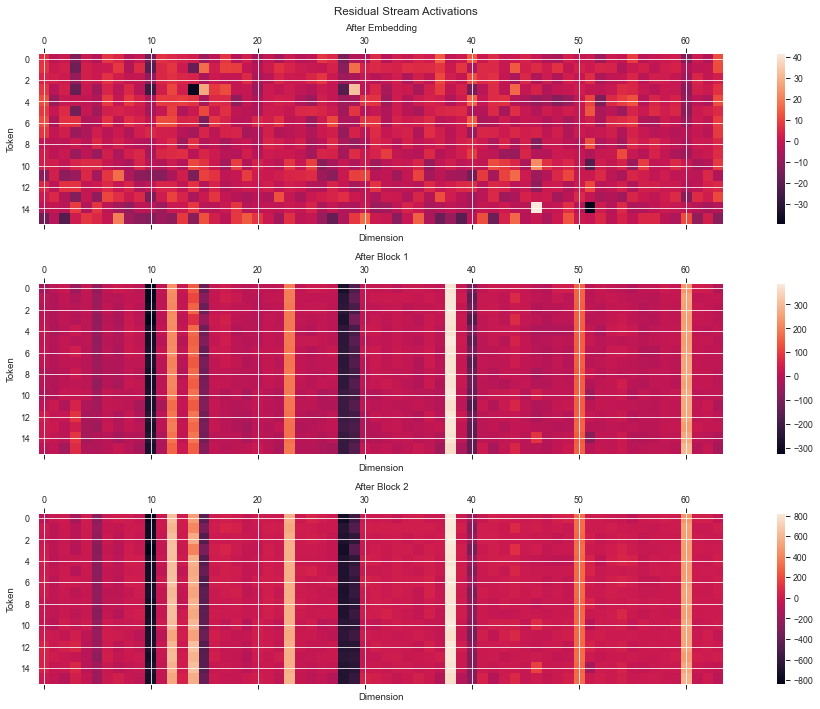

In [129]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
plt.suptitle("Residual Stream Activations")

for ax, activation, label in zip(axes, activations, ["Embedding", "Block 1", "Block 2"]):
    cax = ax.matshow(activation)
    ax.set_title(f"After {label}")
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Token")
    fig.colorbar(cax, ax=ax)

plt.tight_layout()
plt.show()

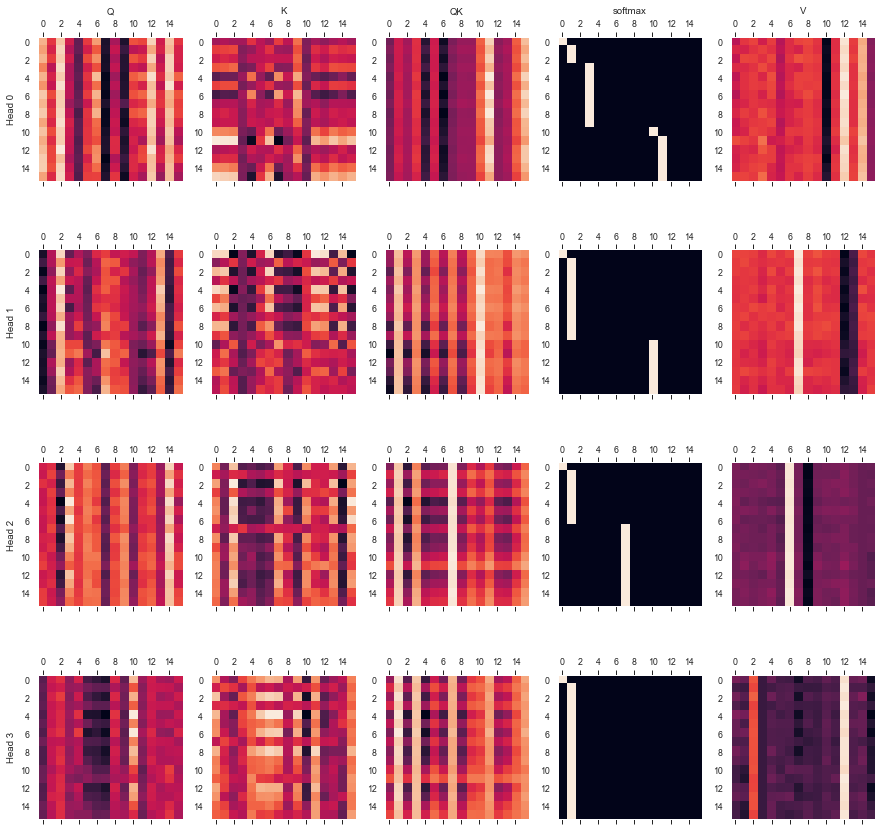

In [152]:
from typing import Optional

def separate_attention(qkv, num_heads, batch_size, head_size, num_tokens):
    return (qkv.view(batch_size, num_tokens, num_heads, 3*head_size)
            .transpose(-2, -3)
            .split(head_size, dim=-1))

def plot_matrix(ax, data, title: Optional[str] = None):
    ax.matshow(data.detach().to("cpu").numpy())
    ax.grid(None)

    if title is not None:
        ax.set_title(title)

def plot_attention(axs, data, titles, num_heads):
    q, k, softmax, v  = data
    qk = (q.unsqueeze(0) @ k.unsqueeze(0).transpose(-2, -1))[0]

    # Rows for each head
    # Columns for Q, K, QK, V
    for j, (name, x) in enumerate(zip(titles, [q, k, qk, softmax, v])):
        axs[0, j].set_title(name)

        for h in range(num_heads):
            plot_matrix(axs[h, j], x[h])

    for h in range(num_heads):
        axs[h, 0].set_ylabel(f"Head {h}")


fig, axes = plt.subplots(4, 5, figsize=(15, 15))
softmax = activations["token_sequence_transformer.blocks.0.attention.attention_softmax"]
q, k, v = separate_attention(activations["token_sequence_transformer.blocks.0.attention.attention"], 4, len(run.evaluator.pretrain_xs), 16, 16)
attn = [q[0], k[0], softmax[0], v[0]]
plot_attention(axes, attn, ["Q", "K", "QK", "softmax", "V"], num_heads=4)

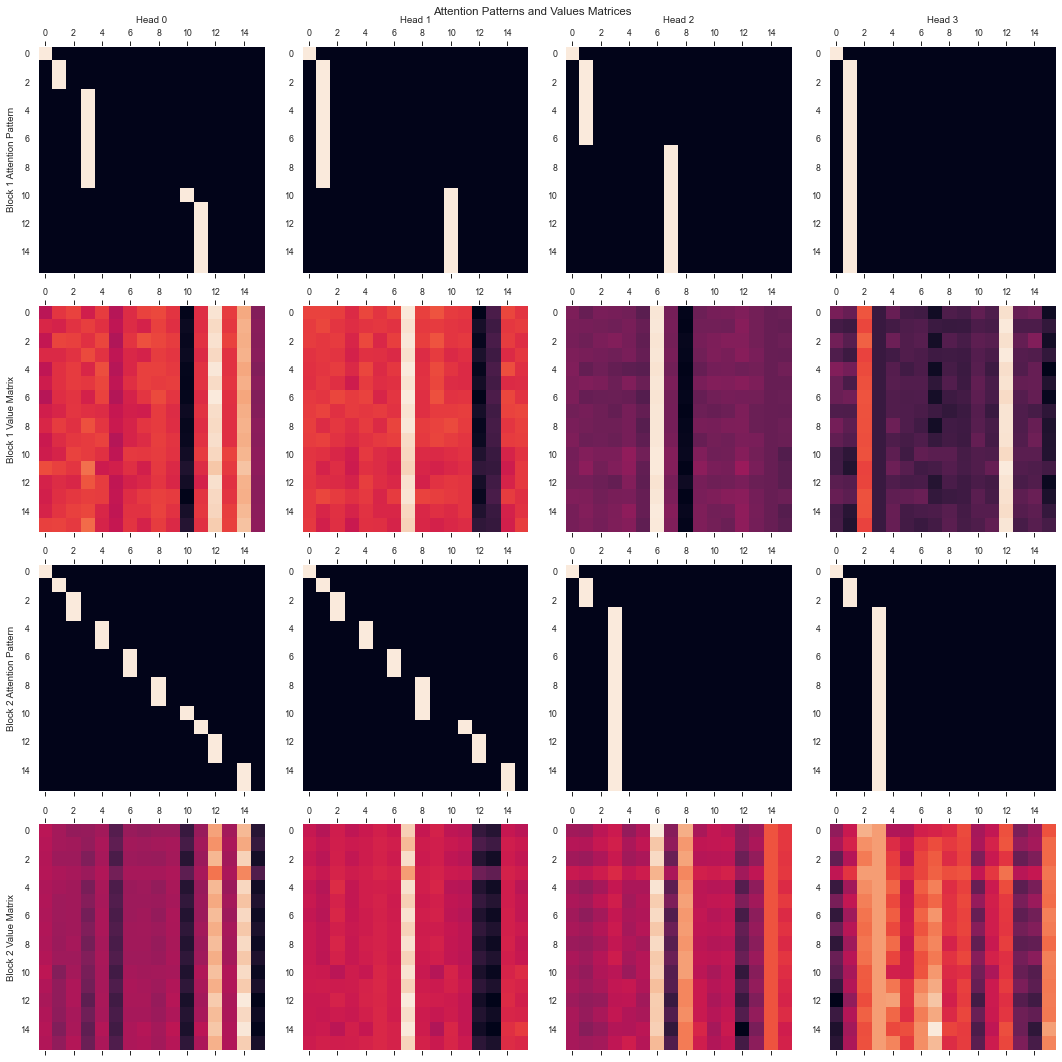

In [158]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

softmax0 = activations["token_sequence_transformer.blocks.0.attention.attention_softmax"][0]
v0 = separate_attention(activations["token_sequence_transformer.blocks.0.attention.attention"], 4, len(run.evaluator.pretrain_xs), 16, 16)[-1][0]

softmax1 = activations["token_sequence_transformer.blocks.1.attention.attention_softmax"][0]
v1 = separate_attention(activations["token_sequence_transformer.blocks.1.attention.attention"], 4, len(run.evaluator.pretrain_xs), 16, 16)[-1][0]

labels = ["Block 1 Attention Patterns", "Block 1 Value Matrices", "Block 2 Attention Patterns", "Block 2 Value Matrices"]

for r, (layer, label) in enumerate(zip([softmax0, v0, softmax1, v1], labels)):
    axes[r, 0].set_ylabel(label)
    for c, x in enumerate(layer):
        plot_matrix(axes[r, c], x, title=None)

for c, label in enumerate(labels):
    axes[0, c].set_title(f"Head {c}")

plt.suptitle("Attention Patterns and Values Matrices")
plt.tight_layout()
plt.savefig("../figures/m1-attn.png", dpi=300)
plt.show()

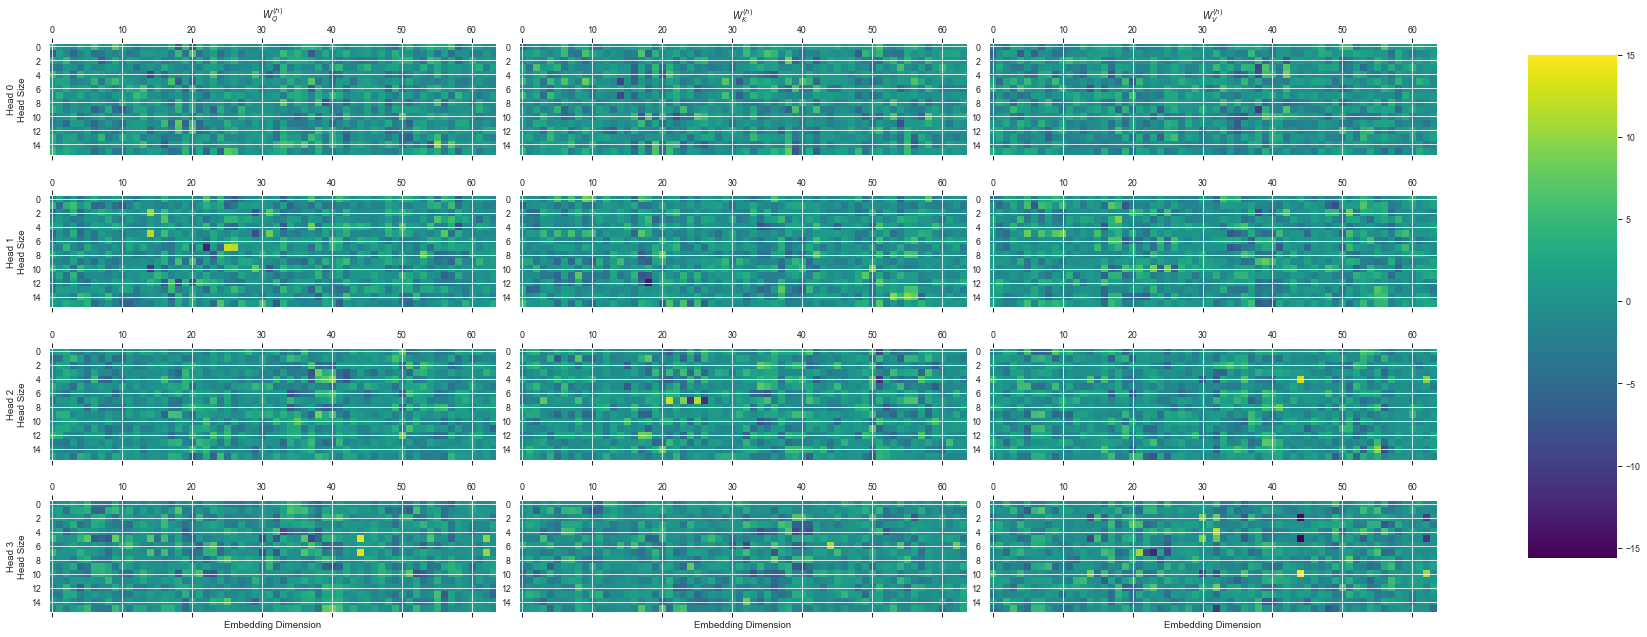

In [163]:
from typing import List
from icl.analysis.utils import (get_sweep_configs, get_unique_config,
                                split_attn_weights)

mat = run.model.token_sequence_transformer.blocks[0].attention.attention.weight.flatten() # .detach().to("cpu").numpy().reshap

def plot_attn_weights(W: torch.Tensor, num_heads: int, embed_dim: int, head_size: int, cols=("$W_Q^{(h)}$", "$W_K^{(h)}$", "$W_V^{(h)}$"), title="", save: Optional[str] = None, rows:Optional[List[str]] =None):
    if len(W.shape) == 1:  # Num heads * Embedding dimension * Head size * 3
        heads = list(split_attn_weights(W, num_heads, embed_dim, head_size))
    elif len(W.shape) == 3:  # Num heads, Embedding dimension, Head size * 3
        heads = [tuple(W[:, h, i*head_size:(i+1)*head_size].T for i in range(3)) for h in range(num_heads)]
    else:
        raise ValueError(f"Expected W to have shape (num_heads, embed_dim, head_size * 3) or (num_heads * embed_dim * head_size * 3), got {W.shape}")

    fig, axs = plt.subplots(num_heads, 3, figsize=(25, 10))
    plt.suptitle(title)

    rows = rows or [f"Head {h}" for h in range(num_heads)]

    min_, max_ = W.min(), W.max()

    for h, head in enumerate(heads):
        axs[h, 0].set_ylabel(f"{rows[h]}\nHead Size")

        for i, mat in enumerate(head):
            axs[h, i].matshow(mat.detach().cpu().numpy().T, cmap='viridis', vmin=min_, vmax=max_) 

    for i, col in enumerate(cols):
        axs[0, i].set_title(col)
        axs[-1, i].set_xlabel("Embedding Dimension")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Plot colorbar somewhere on right
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(axs[0, 0].images[0], cax=cbar_ax)
    

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


plot_attn_weights(mat, 4, 64, 16)

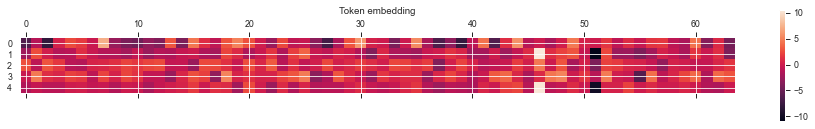

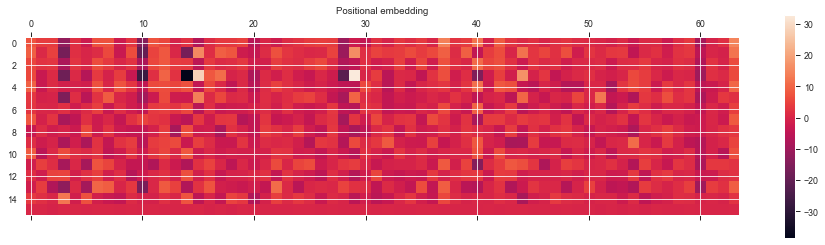

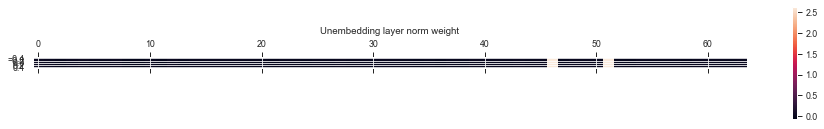

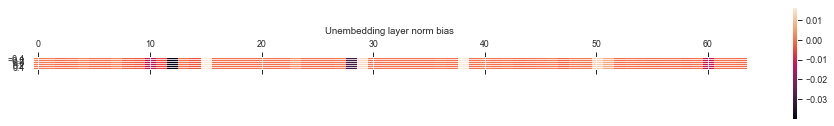

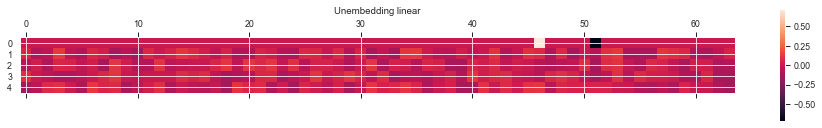

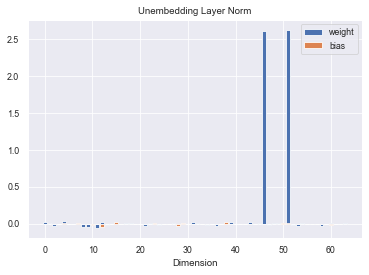

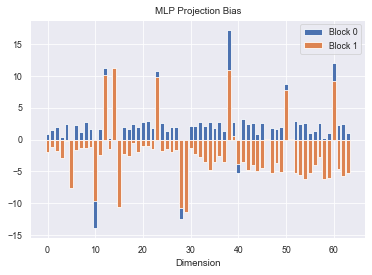

In [131]:
import seaborn as sns
sns.set_theme("paper")

plt.matshow(run.model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy().T)
plt.title("Token embedding")
plt.colorbar()
plt.show()

plt.matshow(run.model.token_sequence_transformer.postn_embedding.weight.detach().cpu().numpy().T)
plt.title("Positional embedding")
plt.colorbar()
plt.show()

plt.matshow(run.model.token_sequence_transformer.unembedding[0].weight.unsqueeze(0).detach().cpu().numpy())
plt.title("Unembedding layer norm weight")
plt.colorbar()
plt.show()


plt.matshow(run.model.token_sequence_transformer.unembedding[0].bias.unsqueeze(0).detach().cpu().numpy())
plt.title("Unembedding layer norm bias")
plt.colorbar()
plt.show()

plt.matshow(run.model.token_sequence_transformer.unembedding[1].weight.detach().cpu().numpy())
plt.title("Unembedding linear")
plt.colorbar()
plt.show()

# Please plot the layernorm weights and biases together as a histogram

plt.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[0].weight.detach().cpu().numpy().flatten(), label="weight")
plt.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[0].bias.detach().cpu().numpy().flatten(), label="bias")
plt.legend()
plt.xlabel("Dimension")
plt.title("Unembedding Layer Norm")
plt.show()

plt.bar(np.arange(64), run.model.token_sequence_transformer.blocks[0].compute[2].bias.detach().cpu().numpy().flatten(), label="Block 0")
plt.bar(np.arange(64), run.model.token_sequence_transformer.blocks[1].compute[2].bias.detach().cpu().numpy().flatten(), label="Block 1")
plt.legend()
plt.xlabel("Dimension")
plt.title("MLP Projection Bias")
plt.show()

In [118]:
run.model.token_sequence_transformer.token_embedding.weight.shape

torch.Size([64, 5])

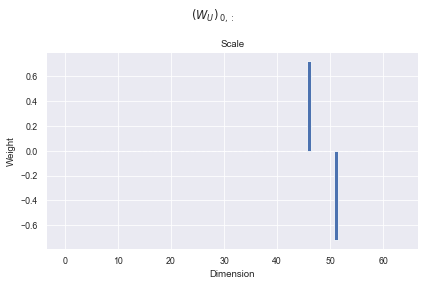

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 1x2 grid of subplots
fig, ax = plt.subplots(1, 1)  # Adjust figsize to desired size

# Plot the weight on the first subplot (ax)
ax.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[1].weight[0, :].detach().cpu().numpy().flatten(), color='b')
ax.set_ylabel('Weight')
ax.set_xlabel("Dimension")
ax.set_title("Scale")

# Set a main title for the entire figure
plt.suptitle("$(W_U)\,_{0,:}$")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

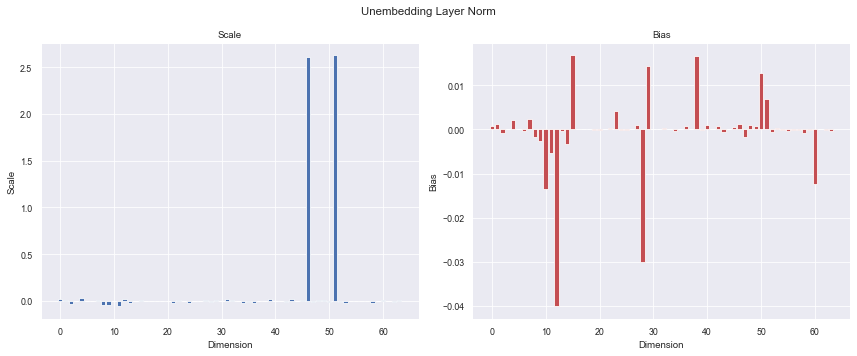

TypeError: only size-1 arrays can be converted to Python scalars

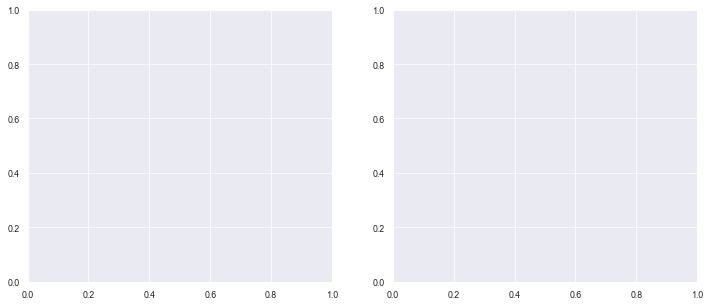

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize to desired size

# Plot the weight on the first subplot (ax1)
ax1.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[0].weight.detach().cpu().numpy().flatten(), color='b')
ax1.set_ylabel('Scale')
ax1.set_xlabel("Dimension")
ax1.set_title("Scale")

# Plot the bias on the second subplot (ax2)
ax2.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[0].bias.detach().cpu().numpy().flatten(), color='r')
ax2.set_ylabel('Bias')
ax2.set_xlabel("Dimension")
ax2.set_title("Bias")

# Set a main title for the entire figure
plt.suptitle("Unembedding Layer Norm")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [88]:
embed46 = run.model.token_sequence_transformer.token_embedding.weight[46]
embed51 = run.model.token_sequence_transformer.token_embedding.weight[51]

with torch.no_grad():
    embed46[0] = 0
    embed51[0] = 0


print("Task weights (normalized):", (run.pretrain_dist.task_distribution.tasks / run.pretrain_dist.task_distribution.tasks.sum()).tolist())
print("Embedding weights (index 46):", (embed46).tolist())
print("Embedding weights (index 51):", (embed51).tolist())
print("Embedding weights (index 46, normalized):", (embed46 / embed46.sum()).tolist())
print("Embedding weights (index 51, normalized):", (embed51 / embed51.sum()).tolist())
print("Embedding weights (averaged across indices 46 and 51, normalized):", ((embed46 / embed46.sum() + embed51 / embed51.sum()) / 2).tolist())


Task weights (normalized): [[0.410453736782074, 0.16566060483455658, 0.03827863931655884, 0.3856070041656494]]
Embedding weights (index 46): [0.0, 10.62821102142334, 4.615780353546143, 0.8649820685386658, 10.451982498168945]
Embedding weights (index 51): [0.0, -10.933765411376953, -4.078135967254639, -1.1483864784240723, -9.843438148498535]
Embedding weights (index 46, normalized): [0.0, 0.40014415979385376, 0.1737806648015976, 0.032565925270318985, 0.39350929856300354]
Embedding weights (index 51, normalized): [-0.0, 0.42046919465065, 0.15682891011238098, 0.044162385165691376, 0.3785395324230194]
Embedding weights (averaged across indices 46 and 51, normalized): [0.0, 0.4103066921234131, 0.1653047800064087, 0.03836415708065033, 0.3860244154930115]


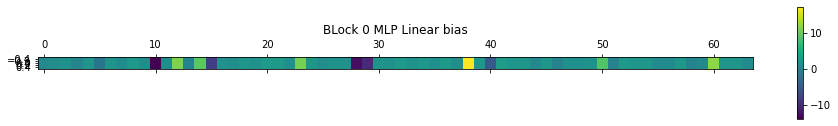

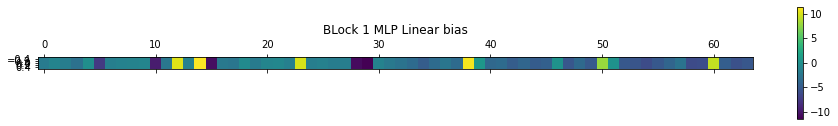

In [87]:
plt.matshow(run.model.token_sequence_transformer.blocks[0].compute[2].bias.unsqueeze(0).cpu().detach().numpy())
plt.title("BLock 0 MLP Linear bias")
plt.colorbar()
plt.show()

plt.matshow(run.model.token_sequence_transformer.blocks[1].compute[2].bias.unsqueeze(0).cpu().detach().numpy())
plt.title("BLock 1 MLP Linear bias")
plt.colorbar()
plt.show()

In [165]:
sum(p.numel() for p in run.model.parameters()) 

43525

In [167]:
run.model.state_dict().keys()

odict_keys(['token_sequence_transformer.token_embedding.weight', 'token_sequence_transformer.postn_embedding.weight', 'token_sequence_transformer.blocks.0.attention.causal_mask', 'token_sequence_transformer.blocks.0.attention.attention.weight', 'token_sequence_transformer.blocks.0.compute.0.weight', 'token_sequence_transformer.blocks.0.compute.0.bias', 'token_sequence_transformer.blocks.0.compute.2.weight', 'token_sequence_transformer.blocks.0.compute.2.bias', 'token_sequence_transformer.blocks.0.layer_norms.0.weight', 'token_sequence_transformer.blocks.0.layer_norms.0.bias', 'token_sequence_transformer.blocks.0.layer_norms.1.weight', 'token_sequence_transformer.blocks.0.layer_norms.1.bias', 'token_sequence_transformer.blocks.1.attention.causal_mask', 'token_sequence_transformer.blocks.1.attention.attention.weight', 'token_sequence_transformer.blocks.1.compute.0.weight', 'token_sequence_transformer.blocks.1.compute.0.bias', 'token_sequence_transformer.blocks.1.compute.2.weight', 'token